In [1]:
from langchain import document_loaders as dl
from langchain import embeddings
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain import text_splitter as ts
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_core.tools import tool
import torch
import faiss
from typing import Annotated, Sequence, Literal, List
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import Image, display
import os
from langchain import hub
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
import json
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
doc_path = 'C:/Users/Carlini/Desktop/Gianluca/scalfari-2021-ms-can-be-considered-a-primary-progressive-disease-in-all-cases-but-some-patients-have-superimposed.pdf'
loader = dl.PyPDFLoader(doc_path)

doc = loader.load()
text_splitter = ts.RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

all_splits = text_splitter.split_documents(doc)

In [3]:
dir_path = 'C:/Users/Carlini/OneDrive - Alma Mater Studiorum Università di Bologna/Articoli/MS'

loader = dl.DirectoryLoader(dir_path, glob='*.pdf', loader_cls=dl.PyPDFLoader, show_progress=True)
doc = loader.load()

text_splitter = ts.RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

all_splits = text_splitter.split_documents(doc)

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:29<00:00,  1.19it/s]


In [4]:
embeddings = OllamaEmbeddings(model="mxbai-embed-large")

index = faiss.IndexFlatL2(len(embeddings.embed_query("Hello world!")))

vector_store = FAISS(embedding_function=embeddings, index=index, docstore=InMemoryDocstore(), index_to_docstore_id={})

_ = vector_store.add_documents(all_splits)


In [5]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

In [6]:
memory = MemorySaver()

In [7]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_question: str
    documents: List[str]

In [8]:
def retrieve(state):
    """
    Retrieve documents from a vector store based on a query.

    Parameters
    ----------
    state (AgentState): The current state

    Returns
    -------
    dict: The updated state with the retrieved documents appended to messages
    """

    print("---RETRIEVE INVOKED---")

    messages = state["messages"]

    question = messages[-1].content

    documents = retriever.invoke(question)

    return {"documents": documents}

def summarize(state):
    """
    Summarize the retrieved documents.

    Parameters
    ----------
    state (AgentState): The current state

    Returns
    -------
    dict: The updated state with the summarized documents appended to messages
    """

    print("---SUMMARIZE INVOKED---")

    prompt = ChatPromptTemplate.from_messages(
    [("human", "Write a summary of the following:\\n\\n{context}")]
)

    model = ChatOllama(model="llama3.2:3b-instruct-fp16", temperature=0)

    chain = create_stuff_documents_chain(model, prompt)

    result = chain.invoke({"context": doc})

    return {"messages": [result]}

def grade_documents(state) -> Literal["generate_rag", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the user query.

    Parameters
    ----------
    state (messages): The current state

    Returns
    -------
    decision: A string indicating the decision
    """


    model = ChatOllama(model="llama3.2:3b-instruct-fp16", temperature=0, format="json")

    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
        Return a JSON with single key 'binary_score', that is either 'yes' of 'no', depending on your decision.""",
        input_variables=["context", "question"],
    )

    chain = prompt | model

    messages = state["messages"]

    question = messages[-1].content
    docs = state["documents"]

    response = chain.invoke({"context": docs, "question": question})

    score = json.loads(response.content)["binary_score"]

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate_rag"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewrite"


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state.
    Given the question, it will decide to retrieve using the retriever tool, or simply end.

    Parameters
    ----------
    state (messages): The current state

    Returns
    -------
    dict: The updated state with the agent response appended to messages
    """

    print("---AGENT INVOKED---")

    template = """
    You are an AI assistant that can help answer questions.
    Given the user question, decide what to do. Your options are to generate an answer, to retrieve documents
    or to summarize the documents.
    Here is the user question: {question}
    Return a JSON with single key 'decision', that is either 'generate', 'retrieve' or 'summarize', depending on the question.
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
    )

    messages = state["messages"]
    user_question = messages[-1].content
    model = ChatOllama(model="llama3-groq-tool-use:8b-fp16", temperature=0, format="json")
    
    chain = prompt | model

    response = chain.invoke(user_question)

    decision = json.loads(response.content)["decision"]

    if decision == "generate":
        print("---DECISION: GENERATE---")
        return "generate"
    elif decision == "retrieve":
        print("---DECISION: RETRIEVE---")
        return "retrieve"
    elif decision == "summarize":
        print("---DECISION: SUMMARIZE---")
        return "summarize"


def rewrite(state):
    """
    Transform the query to produce a better question.

    Parameters
    ----------
    state (messages): The current state

    Returns
    -------
    dict: The updated state with the transformed question appended to messages
    """

    print("---REWRITE INVOKED---")

    messages = state["messages"]
    question = messages[-1].content

    msg = [
        HumanMessage(
            content=f"""\n
        Look at the input and try to reason about the undelying semantic intent / meaning. \n
        Here is the initial question: 
        \n ----------------- \n 
        {question} 
        \n ----------------- \n
        Formulate an improved question. Generate the new question only,
        not your reasoning.
        New question: """,
        )
    ]

    model = ChatOllama(model="llama3.2:3b-instruct-fp16")
    response = model.invoke(msg)

    return {"messages": [response]}

def generate(state):
    """
    Generate an answer without retrieving documents.
    """

    print("---GENERATE INVOKED---")

    messages = state["messages"]
    # question = state["user_question"]

    model = ChatOllama(model="llama3.2:3b-instruct-fp16", temperature=0)

    response = model.invoke(messages)

    return {"messages": [response]}

def generate_rag(state):
    """
    Generate answer

    Parameters
    ----------
    state (messages): The current state

    Returns
    -------
    dict: The updated state with the generated answer appended to messages
    """

    print("---GENERATE RAG INVOKED---")

    messages = state["messages"]
    documents = state["documents"]

    prompt = hub.pull("rlm/rag-prompt")

    llm = ChatOllama(model="llama3.2:3b-instruct-fp16", temperature=0)

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    rag_chain = prompt | llm | StrOutputParser()

    response = rag_chain.invoke({"question": messages[-1].content, "context": documents})

    return {"messages": [response]}

In [9]:
workflow = StateGraph(AgentState)

workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate_rag", generate_rag)
workflow.add_node("generate", generate)
workflow.add_node("summarize", summarize)
# workflow.add_edge(START, "agent")

workflow.set_conditional_entry_point(
    agent,
    {
        "retrieve": "retrieve",
        "generate": "generate",
        "summarize": "summarize",
    }
)

workflow.add_conditional_edges(
    "retrieve",
    grade_documents,)

workflow.add_edge("generate", END)
workflow.add_edge("generate_rag", END)
workflow.add_edge("summarize", END)
workflow.add_edge("rewrite", "retrieve")

graph = workflow.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "abc123"}}

In [14]:
import pprint

inputs = {
    "messages": [
        ("user", "Tell me more"),
    ]
}
for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---AGENT INVOKED---
---DECISION: GENERATE---
---GENERATE INVOKED---
"Output from node 'generate':"
'---'
{ 'messages': [ AIMessage(content="Based on the documents you provided, here is a list of the most common disease-modifying drugs (DMDs) used to treat multiple sclerosis:\n\n1. **Interferons**: A class of proteins that help reduce inflammation and slow down disease progression.\n2. **Glatiramer acetate**: An immunomodulator that helps reduce relapses and slow down disability progression.\n3. **Fingolimod**: A sphingosine 1-phosphate receptor modulator that reduces lymphocyte circulation, leading to reduced inflammation and relapse rates.\n4. **Dimethyl fumarate**: An immunomodulator that has anti-inflammatory properties and helps reduce relapses and disability progression.\n5. **Teriflunomide**: An immunomodulator that inhibits the production of inflammatory cytokines and helps reduce relapses and disability progression.\n6. **Alemtuzumab**: A monoclonal antibody that targets CD52, 

In [ ]:
import pprint

inputs = {
    "messages": [
        ("user", "Is the word 'EDSS' mentioned in the document? Retrieve it from the documents"),
    ]
}
for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---AGENT INVOKED---
---DECISION: RETRIEVE---
---RETRIEVE INVOKED---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'documents': [ Document(metadata={'source': 'C:\\Users\\Carlini\\OneDrive - Alma Mater Studiorum Università di Bologna\\Articoli\\MS\\a_deep_learning_approach_to_predicting_disease_ms.pdf', 'page': 7}, page_content='in the second row, an EDSS worsened patient wrongly classified as stable by the software.\nStorelli et al Investigative Radiology \x81 Volume 57, Number 7, July 2022\n430 www.investigativeradiology.com © 2022 Wolters Kluwer Health, Inc. All rights reserved.\nCopyright © 2022 Wolters Kluwer Health, Inc. All rights reserved.\nDownloaded from http://journals.lww.com/investigativeradiology by BhDMf5ePHKav1zEoum1tQfN4a+kJLhEZgbsIHo4XMi0hCywCX1AWnYQp/IlQrHD3i3D0OdRyi7TvSFl4Cf3VC1y0abggQZXdgGj2MwlZLeI= on 08/23/2024'),
                 Document(metadata={'source': 'C:\\Users\\Carlini\\OneDrive - Alma Mater Studiorum Università di Bologna\\Articol

c:\Users\Carlini\miniconda3\envs\llama\Lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate_rag':"
'---'
{ 'messages': [ "The word 'EDSS' is mentioned in three different documents. It "
                'refers to the Expanded Disability Status Scale, which is used '
                'to assess disability in patients with multiple sclerosis. '
                'EDSS raters are also mentioned as being involved in assessing '
                'patients and collecting data on their disability status.']}
'\n---\n'


: 

In [12]:
import pprint

inputs = {
    "messages": [
        ("user", "Have you ever heard of the legend of darth plagueis the wise?"),
    ]
}
for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---AGENT INVOKED---
---DECISION: GENERATE---
---GENERATE INVOKED---
"Output from node 'generate':"
'---'
{ 'messages': [ AIMessage(content="Hello! I'd be happy to help you understand the documents you have.\n\nThe main topic of these documents appears to be Multiple Sclerosis (MS), a chronic autoimmune disease that affects the central nervous system. The articles cover various aspects of MS, including diagnosis, treatment, management, cognitive impairment, physical disability, comorbidity and social factors, and lifestyle and risk factors.\n\nAs for your question about Darth Plagueis the Wise... I'm not familiar with any legend or story about a character by that name. However, I do know that Darth Plagueis is a fictional character in the Star Wars universe. He's a Sith Lord who is said to have had the power to prevent people from dying, and his legend has become somewhat of a myth among fans.\n\nBut let's get back to your documents! If you'd like, I can help you summarize or analyze th

In [9]:
doc

[Document(metadata={'source': 'C:/Users/Carlini/Desktop/Gianluca/scalfari-2021-ms-can-be-considered-a-primary-progressive-disease-in-all-cases-but-some-patients-have-superimposed.pdf', 'page': 0}, page_content='1002 journals.sagepub.com/home/msj\nMULTIPLE\nSCLEROSIS MSJ\nJOURNAL\nhttps://doi.org/10.1177/13524585211001789\nhttps://doi.org/10.1177/13524585211001789\nMultiple Sclerosis Journal\n2021, Vol. 27(7) 1002 –1007\nDOI: 10.1177/ \n13524585211001789\n© The Author(s), 2021. \n \nArticle reuse guidelines:  \nsagepub.com/journals-\npermissions\nMultiple Sclerosis Journal\n2021, Vol. 27(7) 1002 –1004\nDOI: 10.1177/ \n13524585211001789\n© The Author(s), 2021. \n \nArticle reuse guidelines:  \nsagepub.com/journals-\npermissions\nOnly few multiple sclerosis (MS) patients escape the \nprogressive course if they survive long enough. In the \nmajority of cases, the progression supervenes after a \nvariable latency from the onset of the relapsing remit-\nting phase, but the clinical boundarie

In [13]:
out = graph.invoke(inputs, config=config)


---AGENT INVOKED---
---DECISION: DOCS NOT RELEVANT---
---REWRITE INVOKED---
---AGENT INVOKED---


In [15]:
out["messages"][-1].pretty_print()

================================== Ai Message ==================================

 

Multiple sclerosis (MS) is a chronic autoimmune disease that affects the central nervous system (CNS), which includes the brain, spinal cord, and optic nerves. The symptoms of MS can vary widely from person to person, but common symptoms include:

* Vision problems, such as blurred vision, double vision, or loss of vision
* Muscle weakness, numbness, or tingling in the arms or legs
* Balance and coordination problems
* Difficulty with speech, swallowing, or bladder control
* Fatigue, depression, or anxiety

The exact cause of MS is not known, but it is believed to be an autoimmune disease, where the immune system mistakenly attacks healthy tissue in the CNS. This can lead to damage to the myelin sheath, which surrounds and protects nerve fibers.

Diagnosing MS typically involves a combination of physical exams, medical history, laboratory tests, and imaging studies. The following are some common diagno

In [ ]:
inputs = {
    "messages": [
        ("user", "Which was the first question?"),
    ]
}

for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

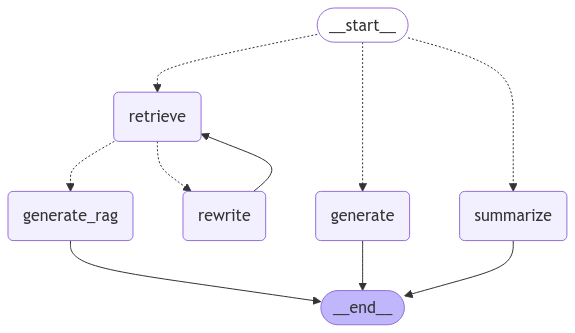

In [19]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
memory = MemorySaver()

state_msg = SystemMessage("You are a chatbot which can retrieve information from documents based on a query.\n"
                          "You should always think about what to do. Do not use any tool if you think it is not necessary.\n")

model = ChatOllama(model="llama3.2:latest")

agent_executor = create_react_agent(model, [retrieve], checkpointer=memory, state_modifier=state_msg)

In [ ]:
config = {"configurable": {"thread_id": "def234"}}
agent_executor.get_state(config=config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': 'def234'}}, metadata=None, created_at=None, parent_config=None, tasks=())

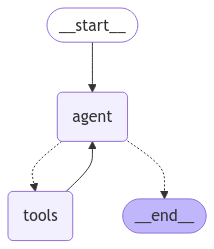

In [ ]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What's your name?"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What's your name?
================================== Ai Message ==================================
Tool Calls:
  retrieve (15c82e66-a4a7-4758-83fa-a316814f1070)
 Call ID: 15c82e66-a4a7-4758-83fa-a316814f1070
  Args:
    query: What is the chatbot's name?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'C:/Users/Carlini/Desktop/Gianluca/scalfari-2021-ms-can-be-considered-a-primary-progressive-disease-in-all-cases-but-some-patients-have-superimposed.pdf', 'page': 1}
Content: comitant epiphenomenon to the primary neuroaxonal 
loss, which potentially promotes the release of highly 
antigenic myelin fragments, secondarily triggering 
the innate and adaptive immune responses. This 
inside-out model would contrast with the traditional 
outside-in view of a primary process, starting in the 
periphery with a dysregulated immune reaction and 
causi

In [ ]:
# config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "Why some scientists do believe that there is no such thing as relapsing-remitting MS? \n"
    "Once you answered, would you show me the parts of the document that support your answer?"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Why some scientists do believe that there is no such thing as relapsing-remitting MS? 
Once you answered, would you show me the parts of the document that support your answer?
================================== Ai Message ==================================
Tool Calls:
  retrieve (dbc240a3-95c1-40db-84e5-5f282d3d4120)
 Call ID: dbc240a3-95c1-40db-84e5-5f282d3d4120
  Args:
    query: Why some scientists do believe that there is no such thing as relapsing-remitting MS?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'C:/Users/Carlini/Desktop/Gianluca/scalfari-2021-ms-can-be-considered-a-primary-progressive-disease-in-all-cases-but-some-patients-have-superimposed.pdf', 'page': 2}
Content: The reasons for the progressive axonal loss are not 
fully known but likely to be multifactorial.
We contend that not all multiple sclerosis (MS) is pro-
gr